<a href="https://colab.research.google.com/github/likeshd/predictive_analysis/blob/main/dart_exponentialsmoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !pip install darts
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet, RNNModel
from darts.metrics import mae
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
data = pd.read_csv('/content/export_public_KPIMain_2024_07_12_12_47_07_090.csv')
# data.head(5)
# Select the necessary columns
data1 = data[["month", "year", "address_id", "kpi_em_Total_Emission"]]

# Create the 'actual_date' column by directly using the year and month columns
data1['actual_date'] = pd.to_datetime(data1.assign(day=1)[['year', 'month', 'day']])

# Sort the DataFrame by 'actual_date' in ascending order
data1.sort_values(by='actual_date', inplace=True)

<ipython-input-5-45c1ba61419a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['actual_date'] = pd.to_datetime(data1.assign(day=1)[['year', 'month', 'day']])
<ipython-input-5-45c1ba61419a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.sort_values(by='actual_date', inplace=True)


In [6]:
# Get unique address_ids
unique_address_ids = data1["address_id"].unique()
# Create a list of DataFrames for each unique address_id
dataframes = []
for address_id in unique_address_ids:
    df = data1[data1['address_id'] == address_id].reset_index(drop=True)
    dataframes.append(df)
print(dataframes[0][:5])
len(dataframes)

   month  year                              address_id  kpi_em_Total_Emission  \
0      4  2021  '86a1eb45-f829-49ad-811c-4129f9e88083'              39.091467   
1      5  2021  '86a1eb45-f829-49ad-811c-4129f9e88083'              34.323174   
2      6  2021  '86a1eb45-f829-49ad-811c-4129f9e88083'              37.937387   
3      7  2021  '86a1eb45-f829-49ad-811c-4129f9e88083'              42.232605   
4      8  2021  '86a1eb45-f829-49ad-811c-4129f9e88083'              40.152530   

  actual_date  
0  2021-04-01  
1  2021-05-01  
2  2021-06-01  
3  2021-07-01  
4  2021-08-01  


3

In [7]:
# Merge all dataframes on 'actual_date', summing 'kpi_em_Total_Emission' where dates overlap
final_df = pd.concat(dataframes).groupby('actual_date', as_index=False)['kpi_em_Total_Emission'].sum()

# Rename the resulting column
# final_df.rename(columns={'kpi_em_Total_Emission': 'kpi_em_Total_Emission_total'}, inplace=True)
# final_df.set_index('actual_date', inplace=True)
final_df

,actual_date,kpi_em_Total_Emission
0,2021-04-01,92.968492
1,2021-05-01,90.633268
2,2021-06-01,94.818566
3,2021-07-01,102.748870
4,2021-08-01,95.259407
5,2021-09-01,94.470112
6,2021-10-01,92.113671
7,2021-11-01,92.627223
8,2021-12-01,101.863899
9,2022-01-01,85.518966


In [8]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(final_df, 'actual_date', 'kpi_em_Total_Emission')

series

<TimeSeries (DataArray) (actual_date: 33, component: 1, sample: 1)>
array([[[ 92.96849242]],

       [[ 90.63326777]],

       [[ 94.81856608]],

       [[102.7488695 ]],

       [[ 95.25940707]],

       [[ 94.47011218]],

       [[ 92.11367053]],

       [[ 92.6272229 ]],

       [[101.86389864]],

       [[ 85.51896606]],

...

       [[120.41601788]],

       [[  0.6481693 ]],

       [[  0.34206692]],

       [[  0.27923966]],

       [[  0.79438776]],

       [[  0.30273948]],

       [[  0.50408512]],

       [[  0.46706276]],

       [[  0.42564596]],

       [[  0.41909032]]])
Coordinates:
  * actual_date  (actual_date) datetime64[ns] 2021-04-01 ... 2023-12-01
  * component    (component) object 'kpi_em_Total_Emission'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [9]:
# Define the split ratio
train_ratio = 0.8

# Calculate the split point
split_point = int(len(series) * train_ratio)

# Split the data into training and testing sets
train_series, test_series = series.split_before(split_point)
train_series

<TimeSeries (DataArray) (actual_date: 26, component: 1, sample: 1)>
array([[[ 92.96849242]],

       [[ 90.63326777]],

       [[ 94.81856608]],

       [[102.7488695 ]],

       [[ 95.25940707]],

       [[ 94.47011218]],

       [[ 92.11367053]],

       [[ 92.6272229 ]],

       [[101.86389864]],

       [[ 85.51896606]],

...

       [[ 93.97557926]],

       [[ 90.36347408]],

       [[ 97.6806355 ]],

       [[ 93.65699661]],

       [[ 90.03828908]],

       [[113.98295453]],

       [[110.17260692]],

       [[120.41601788]],

       [[  0.6481693 ]],

       [[  0.34206692]]])
Coordinates:
  * actual_date  (actual_date) datetime64[ns] 2021-04-01 ... 2023-05-01
  * component    (component) object 'kpi_em_Total_Emission'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [10]:
test_series

<TimeSeries (DataArray) (actual_date: 7, component: 1, sample: 1)>
array([[[0.27923966]],

       [[0.79438776]],

       [[0.30273948]],

       [[0.50408512]],

       [[0.46706276]],

       [[0.42564596]],

       [[0.41909032]]])
Coordinates:
  * actual_date  (actual_date) datetime64[ns] 2023-06-01 ... 2023-12-01
  * component    (component) object 'kpi_em_Total_Emission'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [24]:
# train, val = series.split_before(pd.Timestamp('19580101'))

In [19]:
from darts.models import ExponentialSmoothing
model = ExponentialSmoothing()
model.fit(train_series)
forecast_horizon = 12
# forecast = model.predict(forecast_horizon)
# forecast

prediction = model.predict((len(test_series)) + forecast_horizon)
p = prediction[(len(test_series)):]
p_plot = prediction[(len(test_series)) - 1:]
p

<TimeSeries (DataArray) (actual_date: 12, component: 1, sample: 1)>
array([[[73.60983082]],

       [[78.92047159]],

       [[77.17373575]],

       [[61.6827075 ]],

       [[26.56265776]],

       [[50.59410664]],

       [[52.82044617]],

       [[50.93936136]],

       [[48.64167166]],

       [[51.23142465]],

       [[49.35713386]],

       [[52.00948752]]])
Coordinates:
  * actual_date  (actual_date) datetime64[ns] 2024-01-01 ... 2024-12-01
  * component    (component) object 'kpi_em_Total_Emission'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

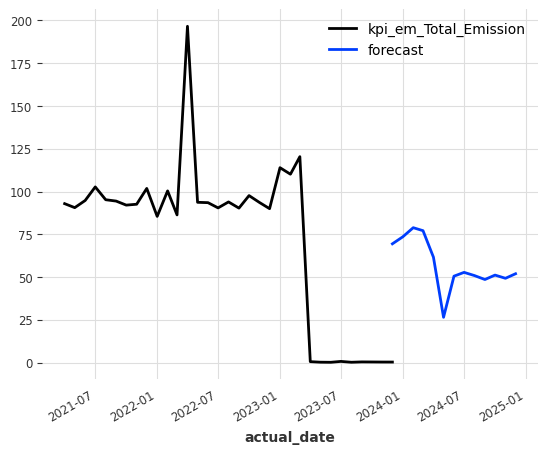

In [20]:
import matplotlib.pyplot as plt

series.plot()
p_plot.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [21]:
from darts.models import ExponentialSmoothing
import pandas as pd

# Fit the model
model = ExponentialSmoothing()
model.fit(train_series)
# Monthly Forecast
forecast_horizon_months = 12
monthly_prediction = model.predict((len(test_series)) + forecast_horizon_months)
monthly_p = monthly_prediction[(len(test_series)):]
monthly_p_plot = monthly_prediction[(len(test_series)) - 1:]

# Quarterly Forecast
forecast_horizon_quarters = 4  # 4 quarters in a year
quarterly_prediction = model.predict((len(test_series)) + (forecast_horizon_quarters * 3))
quarterly_p = quarterly_prediction[(len(test_series)):]
quarterly_p = quarterly_p.pd_dataframe().resample('Q').mean()  # Resampling to quarterly
quarterly_p_plot = quarterly_prediction[(len(test_series)) - 1:]
quarterly_p_plot = quarterly_p_plot.pd_dataframe().resample('Q').mean()  # Resampling to quarterly

# Yearly Forecast
forecast_horizon_years = 1  # 1 year
yearly_prediction = model.predict((len(test_series)) + (forecast_horizon_years * 12))
yearly_p = yearly_prediction[(len(test_series)):]
yearly_p = yearly_p.pd_dataframe().resample('Y').mean()  # Resampling to yearly
yearly_p_plot = yearly_prediction[(len(test_series)) - 1:]
yearly_p_plot = yearly_p_plot.pd_dataframe().resample('Y').mean()  # Resampling to yearly

# Print predictions
print("Monthly Predictions:\n", monthly_p)
print("Quarterly Predictions:\n", quarterly_p)
print("Yearly Predictions:\n", yearly_p)



Monthly Predictions:
 <TimeSeries (DataArray) (actual_date: 12, component: 1, sample: 1)>
array([[[73.60983082]],

       [[78.92047159]],

       [[77.17373575]],

       [[61.6827075 ]],

       [[26.56265776]],

       [[50.59410664]],

       [[52.82044617]],

       [[50.93936136]],

       [[48.64167166]],

       [[51.23142465]],

       [[49.35713386]],

       [[52.00948752]]])
Coordinates:
  * actual_date  (actual_date) datetime64[ns] 2024-01-01 ... 2024-12-01
  * component    (component) object 'kpi_em_Total_Emission'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
Quarterly Predictions:
 component    kpi_em_Total_Emission
actual_date                       
2024-03-31               76.568013
2024-06-30               46.279824
2024-09-30               50.800493
2024-12-31               50.866015
Yearly Predictions:
 component    kpi_em_Total_Emission
actual_date                       
2024-12-31               56.128

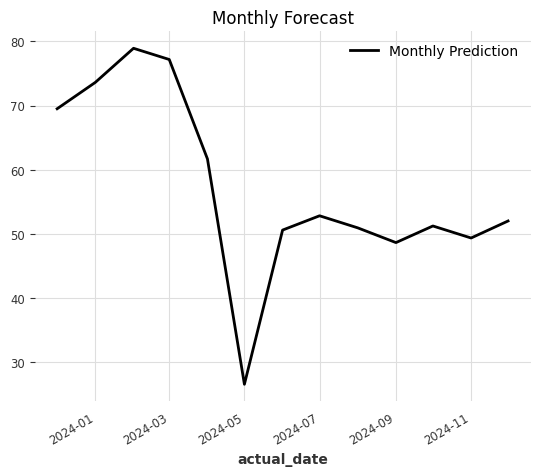

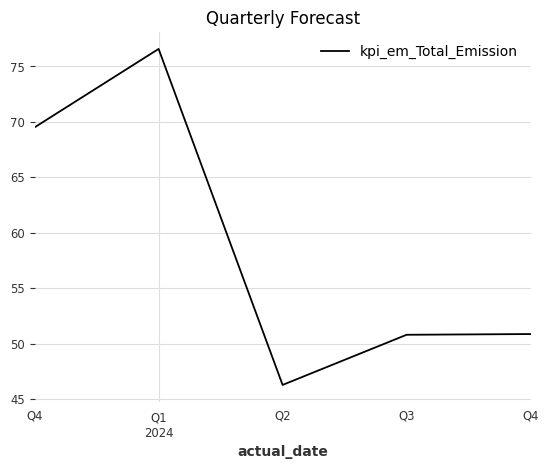

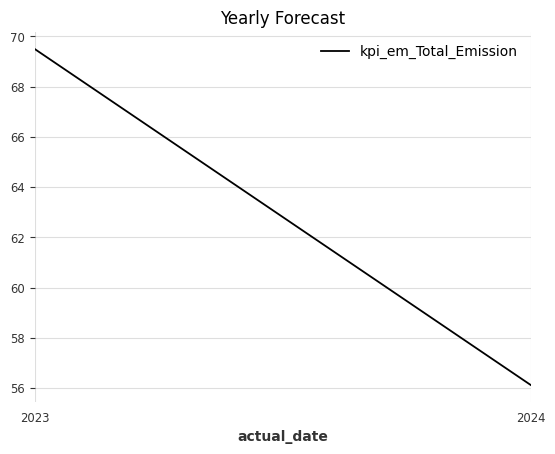

In [22]:
# Plotting the results
# import matplotlib.pyplot as plt

# Monthly Plot
monthly_p_plot.plot(label='Monthly Prediction')
plt.title('Monthly Forecast')
plt.legend()
plt.show()

# Quarterly Plot
quarterly_p_plot.plot(label='Quarterly Prediction')
plt.title('Quarterly Forecast')
plt.legend()
plt.show()

# Yearly Plot
yearly_p_plot.plot(label='Yearly Prediction')
plt.title('Yearly Forecast')
plt.legend()
plt.show()

In [54]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train_series)
forecast_horizon = 6
# forecast = model.predict(forecast_horizon)
# forecast

prediction1 = model_aarima.predict((len(test_series)) + forecast_horizon)
prediction1[(len(test_series)):]

<TimeSeries (DataArray) (actual_date: 6, component: 1, sample: 1)>
array([[[92.90466131]],

       [[92.90466131]],

       [[92.90466131]],

       [[92.90466131]],

       [[92.90466131]],

       [[92.90466131]]])
Coordinates:
  * actual_date  (actual_date) datetime64[ns] 2024-01-01 ... 2024-06-01
  * component    (component) object 'kpi_em_Total_Emission'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

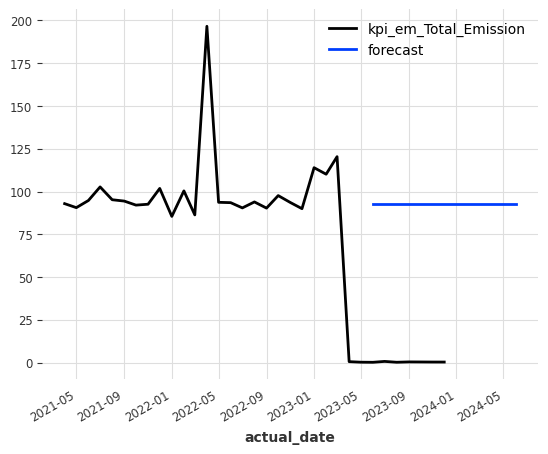

In [55]:
import matplotlib.pyplot as plt

series.plot()
prediction1.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [64]:
from darts.datasets import AirPassengersDataset
from darts.models import Prophet
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# series = AirPassengersDataset().load()
# optionally, use some future covariates; e.g. the value of the month encoded as a sine and cosine series
# future_cov = datetime_attribute_timeseries(series, "month", cyclic=True, add_length=6)
# adding a seasonality (daily, weekly and yearly are included by default) and holidays
model = Prophet(
    add_seasonalities={
        'name':"quarterly_seasonality",
        'seasonal_periods':4,
        'fourier_order':5
        },
)
model.fit(series)
pred = model.predict(6)
pred.values()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qizir05/ycj8it1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qizir05/qh0mrdxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86309', 'data', 'file=/tmp/tmp7qizir05/ycj8it1p.json', 'init=/tmp/tmp7qizir05/qh0mrdxu.json', 'output', 'file=/tmp/tmp7qizir05/prophet_model6mkmqlcu/prophet_model-20240716122636.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


array([[ 88.20376696],
       [ 43.32462727],
       [-80.28573768],
       [-14.16760675],
       [-69.25162032],
       [-80.57483131]])